In [ ]:
import os
import shutil

os.system("git clone https://github.com/matt-nann/AuthenticCursor.git")
try:
  shutil.copytree("AuthenticCursor/src", "src")
except:
  ...
shutil.copy("AuthenticCursor/requirementsGAN.txt", "requirementsGAN.txt")
os.system("pip install -r requirementsGAN.txt")
shutil.rmtree("AuthenticCursor")

24.5%

100.0%


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100.0%

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw




100.0%
100.0%


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Epoch [1/50], Step [200/469], d_loss: 1.9557, g_loss: -18.6211
Epoch [1/50], Step [400/469], d_loss: -1.6247, g_loss: -11.7384


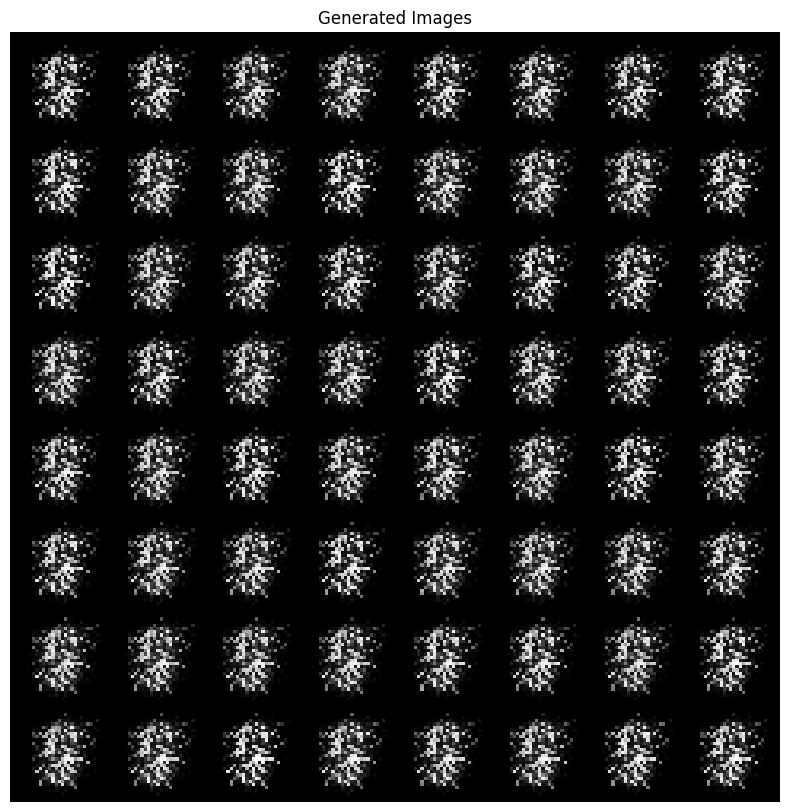

Epoch [2/50], Step [200/469], d_loss: -3.9117, g_loss: -3.3157
Epoch [2/50], Step [400/469], d_loss: -5.7067, g_loss: 3.3076
Epoch [3/50], Step [200/469], d_loss: -5.5443, g_loss: -0.6881
Epoch [3/50], Step [400/469], d_loss: -7.3180, g_loss: 0.7345


In [5]:

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.fc(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_kernels, kernel_dim):
        super(Discriminator, self).__init__()
        self.minibatch_discrimination = MinibatchDiscrimination(input_dim, num_kernels, kernel_dim)
        self.fc = nn.Sequential(
            # nn.Linear(input_dim, 512),
            nn.Linear(input_dim + num_kernels, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
    def forward(self, x):
        x = self.minibatch_discrimination(x)
        return self.fc(x)

# Minibatch Discrimination
class MinibatchDiscrimination(nn.Module):
    def __init__(self, input_features, num_kernels, kernel_dim):
        super(MinibatchDiscrimination, self).__init__()
        self.input_features = input_features
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(input_features, num_kernels * kernel_dim))

    def forward(self, x):
        M = torch.matmul(x, self.T).view(-1, self.num_kernels, self.kernel_dim)
        diffs = M.unsqueeze(0) - M.transpose(0, 1).unsqueeze(2)
        abs_diffs = torch.sum(torch.abs(diffs), dim=2)
        minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2).T
        return torch.cat((x, minibatch_features), dim=1)

# Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples, phi=1):
    assert real_samples.shape == fake_samples.shape
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1)).to(device).requires_grad_(False)
    real_samples.requires_grad_(True)
    fake_samples.requires_grad_(True)
    # Get random interpolation between real and fake samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    # calculate probability of interpolated examples
    with torch.backends.cudnn.flags(enabled=False):
        prob_interpolated = D(interpolated)
    ones = torch.ones(prob_interpolated.size()).to(device).requires_grad_(True)
    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=ones,
        create_graph=True)[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = (
        torch.mean((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2)
    )   
    return gradient_penalty

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 128
num_epochs = 50
learning_rate = 0.0002
num_kernels = 5
kernel_dim = 3
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataset = MNIST(root="../data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
#     device = torch.device("mps")

generator = Generator(latent_dim, image_size).to(device)
discriminator = Discriminator(image_size, num_kernels, kernel_dim).to(device)

# Loss weights
real_label = -1.
fake_label = 1.

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

# Training Loop
total_steps = len(dataloader)
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        _batch_size = real_images.size(0)
        real_images = real_images.view(_batch_size, -1).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        generator_optimizer.zero_grad()

        z = torch.randn(_batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_validity = discriminator(fake_images)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        generator_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator_optimizer.zero_grad()

        real_validity = discriminator(real_images)
        fake_validity = discriminator(fake_images.detach())

        gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, fake_images.data)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        discriminator_optimizer.step()

        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    if epoch % 5 == 0:
        with torch.no_grad():
            z = torch.randn(64, latent_dim).to(device)
            fake_images = generator(z)

        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=8, padding=2, normalize=True).permute(1, 2, 0))
        plt.show()
